# This code implements a simple Bayesian forward model for a hypothetical electron spectrometer with simple Gaussian response functions. The energy channel middles and widths are taken from the MagEIS LOW detector.

Overall, this code creates the fake population and observed counts from a spectra specified by the user for validation purposes. Then the model conists of specifing the prior which is taken to be uniform distributions of  E0  and  J0 . The likeleyhood is then the integral of the sampled spectra folded through the instrument response.

Since there are 7 energy channels, I've had to specify the folding step into a function in order for this model to work in pymc3.

The Gaussain instrument response for the spectrometer (loosely based on MagEIS) is found in mageis_response.py

The code was inspired by Isaac Michaud ijmichau@ncsu.edu.

In [54]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

In [55]:
# Set this true if you want the plots saved.
save_plots = False

if save_plots:
    from datetime import datetime
    import os
    
    plotDir = '../plots/{}'.format(datetime.now().date())
    if not os.path.exists(plotDir):
        os.makedirs(plotDir)
        print('Made plotting directory: {}'.format(plotDir))

### Make a fake spectra and get the true counts. Then draw the "observed" counts assuming a Poisson process.

In [56]:
# Spectra parameters
E0t = 100
J0t = 200 

# Reponse parameters
R0 = 1e-2

# Energy array to descritize the spectra and response function
Earr = np.linspace(1, 300, num=1000) 
dE = Earr[1] - Earr[0] # To do the integral.

# Initialize the response function
R = mageis_response.R_gaus()

def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

def true_spectra(Earr, J0t, E0t):
    return spectra(Earr, J0t, E0t)

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(7)
for i in range(7):
    true_lambda[i] = dE*np.dot(true_spectra(Earr, J0t, E0t), 
                               R.response(R0=R0, Earr=Earr, ch=i))

Visualize the "true" spectra as well as the instrument response functions.

In [57]:
plt.plot(Earr, true_spectra(Earr, J0t, E0t)); plt.title('True energy spectra');
plt.ylabel('Flux [unitless]'); plt.xlabel('Energy [keV]');
if save_plots:
    plt.savefig('{}/true_spectra.png'.format(plotDir), dpi=300)

In [58]:
for i in range(7):
    plt.plot(Earr, R.response(R0=R0, Earr=Earr, ch=i))
plt.title('Gaussian response functions R0={}'.format(R0)); 
plt.ylabel('Responce [unitless]'); plt.xlabel('Energy [keV]');
if save_plots:
    plt.savefig('{}/response_functions.png'.format(plotDir), dpi=300)

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [59]:
np.random.seed(123) # For reproducability.
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

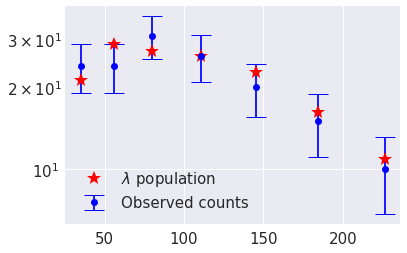

In [60]:
(_, caps, _) = plt.errorbar(R.mu, c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(R.mu, true_lambda, 'r*', ms=15, label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();
if save_plots:
    plt.savefig('{}/population_sample_counts.png'.format(plotDir), dpi=300)

Sanity check: c_obs counts are drawn from lambda counts.

# Bayes model


In [61]:
m = pm.Model()

def lam(J, E0):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the 7 instrument response functions.
    """
    lams = 7*[None]
    for i in range(len(c_obs)):
        lams[i] = pm.Deterministic(
            'lam{}'.format(i),
            dE*pm.math.dot(J, R.response(R0=R0, Earr=Earr, ch=i))
                              )
    return lams

with m:
    # Prior stocastic variables
    J0 = pm.Uniform('J0', lower=1, upper=1E6)
    E0 = pm.Uniform('E0', lower=1, upper=500)
    
    # Define an exponential spectra
    #J = pm.Deterministic('J', J0*pm.math.exp(-Earr/E0)) # I don't think it needs to be Deterministic
    J = J0*pm.math.exp(-Earr/E0)
    
    lams = lam(J, E0)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=2000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_interval__, J0_interval__]
100%|██████████| 10500/10500.0 [00:21<00:00, 479.20it/s]
The acceptance probability does not match the target. It is 0.888149908965838, but should be close to 0.8. Try to increase the number of tuning steps.


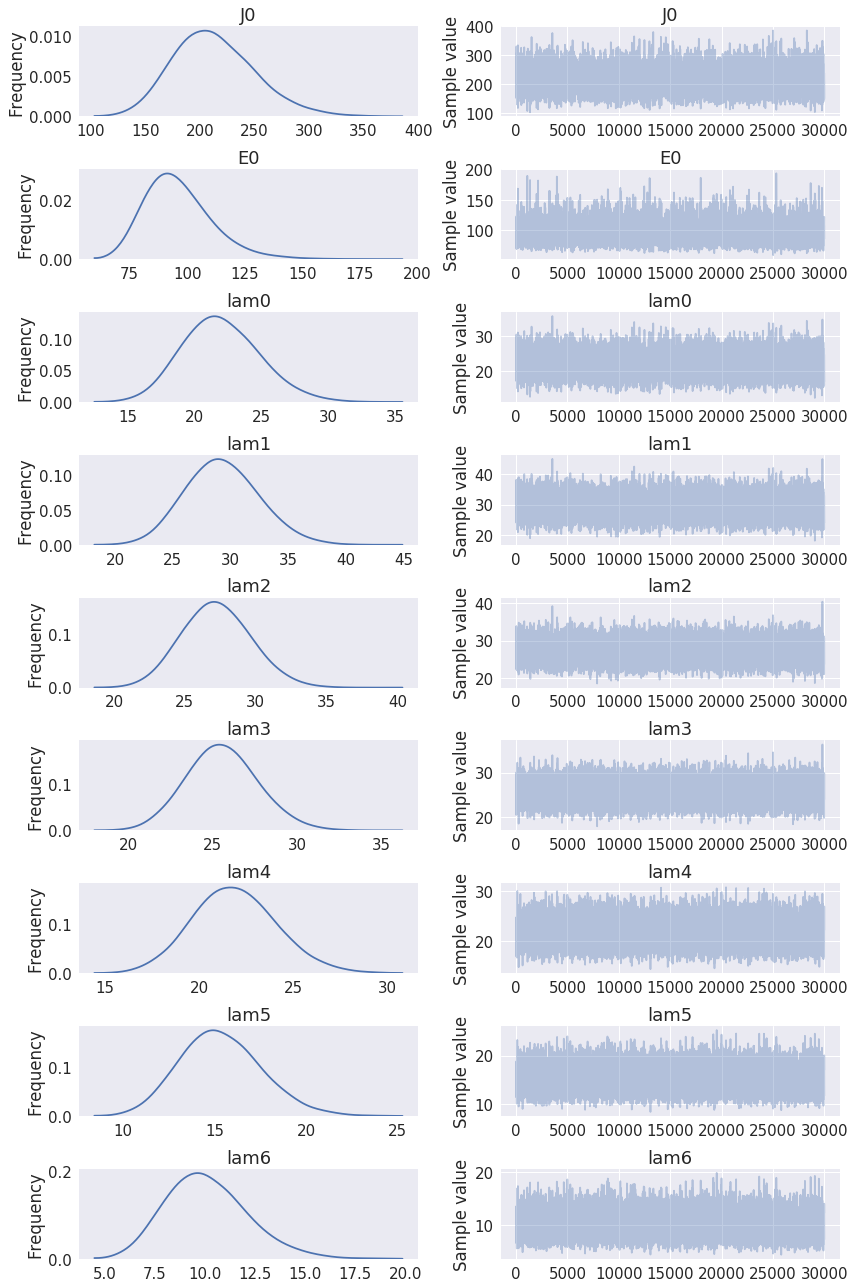

In [62]:
pm.traceplot(trace, combined=True);
if save_plots:
    plt.savefig('{}/traceplot.png'.format(plotDir), dpi=300)

In [63]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5    hpd_97.5         n_eff  \
J0    212.517686  37.347428  0.403609  142.996937  287.470203   7801.094494   
E0     96.020622  14.671689  0.161188   70.285786  125.069617   7571.729610   
lam0   21.918717   2.862233  0.029382   16.764243   27.932050   8495.189957   
lam1   29.244329   3.157363  0.030179   23.209872   35.497828   9695.483665   
lam2   27.200163   2.410769  0.019466   22.576012   31.969306  13647.877920   
lam3   25.522391   2.096182  0.012943   21.370489   29.552837  26462.053487   
lam4   21.862062   2.221176  0.016155   17.636468   26.349799  21168.721592   
lam5   15.310420   2.214914  0.019670   11.007105   19.594811  13174.704747   
lam6   10.092332   2.035644  0.019758    6.348632   14.184716  10546.449910   

          Rhat  
J0    1.000106  
E0    1.000073  
lam0  1.000069  
lam1  1.000039  
lam2  0.999999  
lam3  0.999980  
lam4  1.000020  
lam5  1.000051  
lam6  1.000060

In [64]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) for i in range(len(c_obs))])
c_Err


array([[16.77032761, 27.94214302],
       [23.4317089 , 35.77145997],
       [22.67946895, 32.11091791],
       [21.57922089, 29.81892208],
       [17.71877313, 26.47851708],
       [11.32350057, 19.98481686],
       [ 6.58705228, 14.55044214]])

Now plot the observed counts vs the counts derived from the posterior

Brian's method

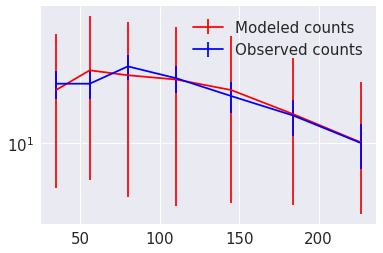

In [65]:
plt.errorbar(R.mu, c_mean, yerr=c_Err.T, c='r', label='Modeled counts'); 
plt.errorbar(R.mu, c_obs, yerr=np.sqrt(c_obs), c='b', label='Observed counts'); 
plt.yscale('log'); plt.legend();
if save_plots:
    plt.savefig('{}/modeleted_and_observed_counts_bl.png'.format(plotDir), dpi=300)

My method

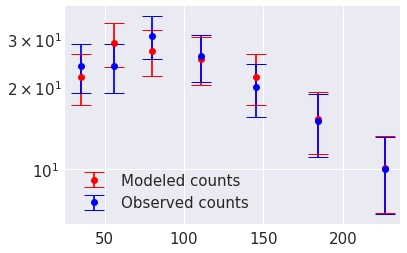

In [66]:
(_, caps, _) = plt.errorbar(R.mu, c_mean, yerr=np.sqrt(c_mean), c='r', fmt='o', 
                            capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
(_, caps, _) = plt.errorbar(R.mu, c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o',
                            label='Observed counts', capsize=10); 
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.yscale('log'); plt.legend();
if save_plots:
    plt.savefig('{}/modeleted_and_observed_counts_ms.png'.format(plotDir), dpi=300)

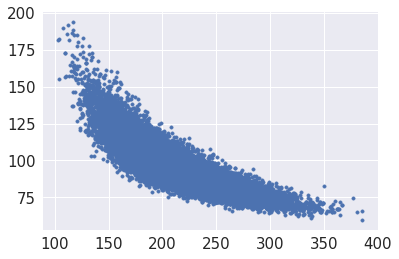

In [67]:
plt.scatter(trace['J0'], trace['E0'], marker='.');
if save_plots:
    plt.savefig('{}/posterior_scatter.png'.format(plotDir), dpi=300)

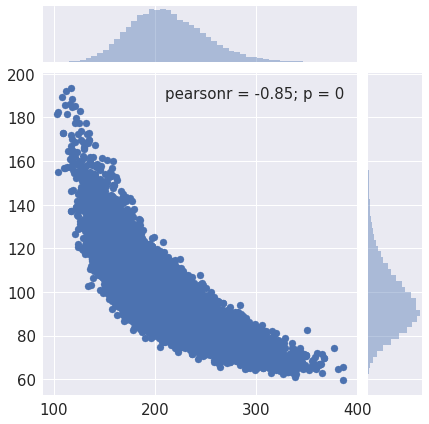

In [68]:
sns.jointplot(trace['J0'], trace['E0']);

True value is 200


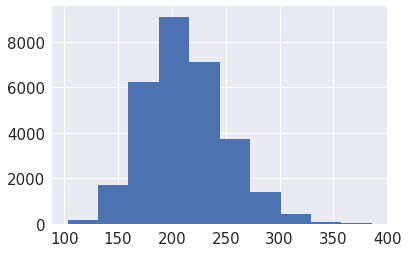

In [69]:
plt.hist(trace['J0']); print('True value is', J0t)
if save_plots:
    plt.savefig('{}/J0_posterior.png'.format(plotDir), dpi=300)

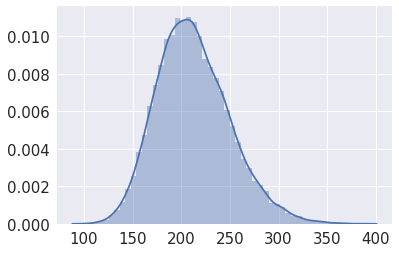

In [70]:
sns.distplot(trace['J0']);

True value is 100


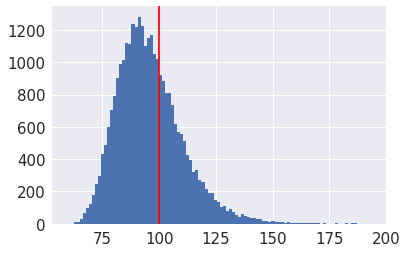

In [71]:
plt.hist(trace['E0'], bins=100); print('True value is', E0t)
plt.axvline(E0t, c='r')
if save_plots:
    plt.savefig('{}/E0_posterior.png'.format(plotDir), dpi=300)

In [72]:
np.median(trace['E0'])

94.13715770868298

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [73]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

100%|██████████| 2000/2000 [00:01<00:00, 1123.66it/s]


In [74]:
ppc.keys()

dict_keys(['c_m'])

In [75]:
c_obs

array([24, 24, 31, 26, 20, 15, 10])

In [76]:
fig, ax = plt.subplots(7,1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)
if save_plots:
    plt.savefig('{}/posterior_checks.png'.format(plotDir), dpi=300)

It appears that the observed counts are more or less centered on the sampled posterior distribution. This validates our posterior, and confirms that draws from it represents the data.

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [77]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(Earr), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(Earr)):
        dist[e, i] = true_spectra(Earr, trace['J0'][s], trace['E0'][s])[e]

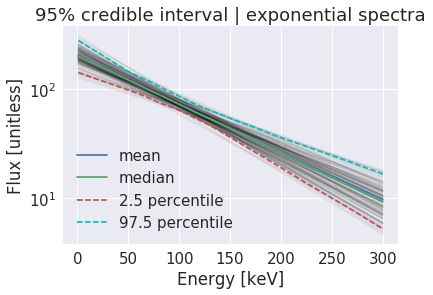

In [78]:
for i in random_samples:
    plt.plot(Earr, true_spectra(Earr, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(Earr, np.mean(dist, axis=1), label='mean');
plt.plot(Earr, np.median(dist, axis=1), label='median');
plt.plot(Earr, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(Earr, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');
if save_plots:
    plt.savefig('{}/spectra_credible_interval.png'.format(plotDir), dpi=300)